# 1. Calibración de cámaras
La calibración de cámara es esencial para cualquier aplicación de visión que requiera mediciones precisas o reconstrucción 3D. Permite:
- Corregir distorsiones de lente
- Establecer la relación entre coordenadas del mundo real y píxeles
- Obtener parámetros intrínsecos (matriz K, coeficientes de distorsión)

Este enlace contiene una guía para calibrar imágenes https://classroom.google.com/c/NzgwMDM2NDYwMzA5/m/ODEwMDkzMTg1MTgy/details

Para el reporte, deben incluir:
- Mostrar 4-6 imágenes con las esquinas detectadas dibujadas
- Código: cv2.drawChessboardCorners()
- Matriz de cámara K:
K = [fx 0 cx] 
       [0 fy cy] 
       [0 0    1]
- Coeficientes de distorsión: k1, k2, p1, p2, k3
- Error RMS de reproyección (debe ser < 0.5 píxeles para buena calibración)
- Mostrar al menos 3 imágenes originales vs. corregidas
- Evidenciar especialmente la corrección en las esquinas (donde la distorsión es mayor)
- ¿Qué tipo de distorsión predomina? (barril, cojín)
- ¿La longitud focal fx es similar a fy? ¿Por qué podría diferir?
- ¿El punto principal (cx, cy) está cerca del centro de la imagen?

In [ ]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt

Imágenes encontradas: 12
1. ./Imágenes Calibración/IMG_20251007_112001990.jpg
2. ./Imágenes Calibración/IMG_20251007_112300784.jpg
3. ./Imágenes Calibración/IMG_20251007_112252274.jpg
4. ./Imágenes Calibración/IMG_20251007_112318642.jpg
5. ./Imágenes Calibración/IMG_20251007_112201026.jpg
6. ./Imágenes Calibración/IMG_20251007_112145218.jpg
7. ./Imágenes Calibración/IMG_20251007_112022738.jpg
8. ./Imágenes Calibración/IMG_20251007_112137001.jpg
9. ./Imágenes Calibración/IMG_20251007_112038963.jpg
10. ./Imágenes Calibración/IMG_20251007_112310310.jpg
11. ./Imágenes Calibración/IMG_20251007_112125709.jpg
12. ./Imágenes Calibración/IMG_20251007_112030566.jpg


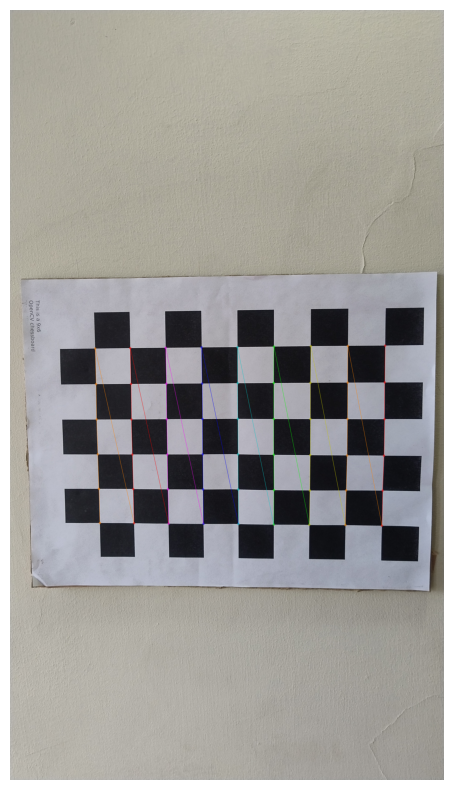

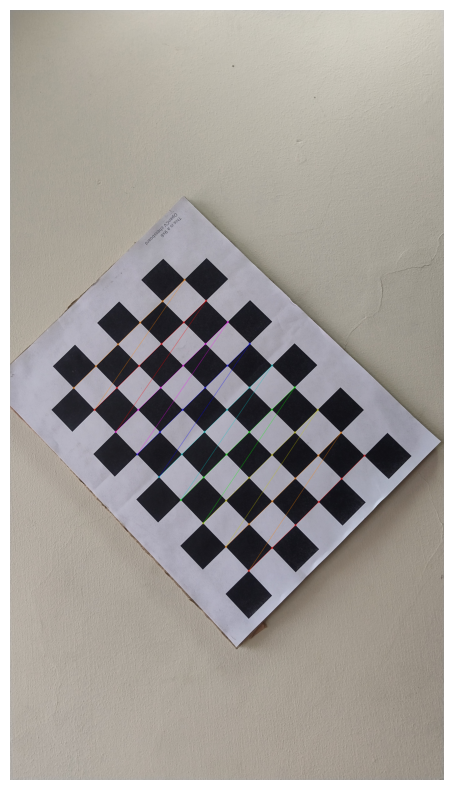

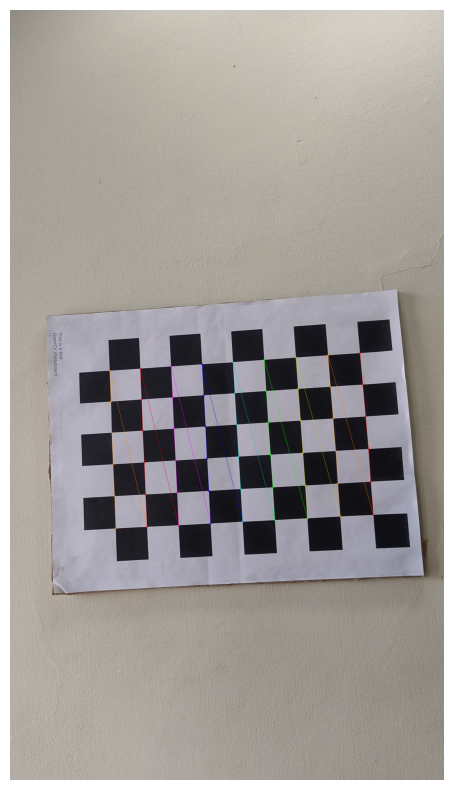

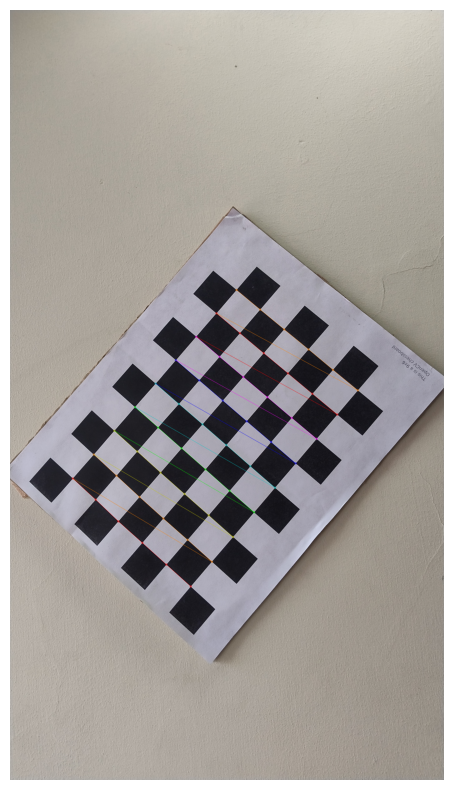

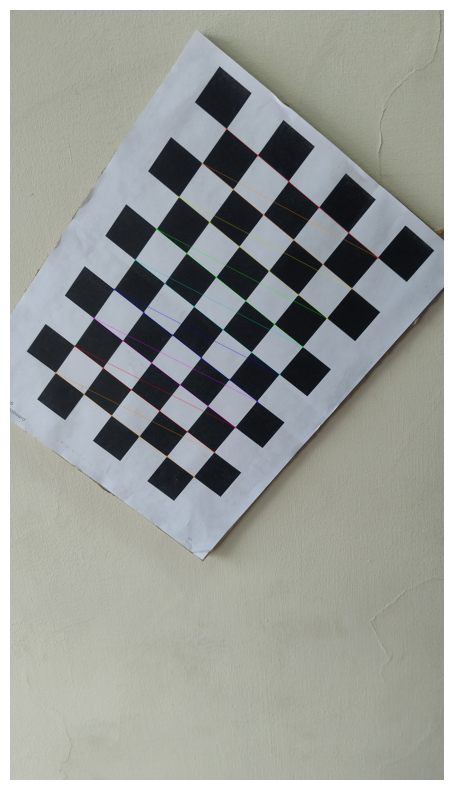

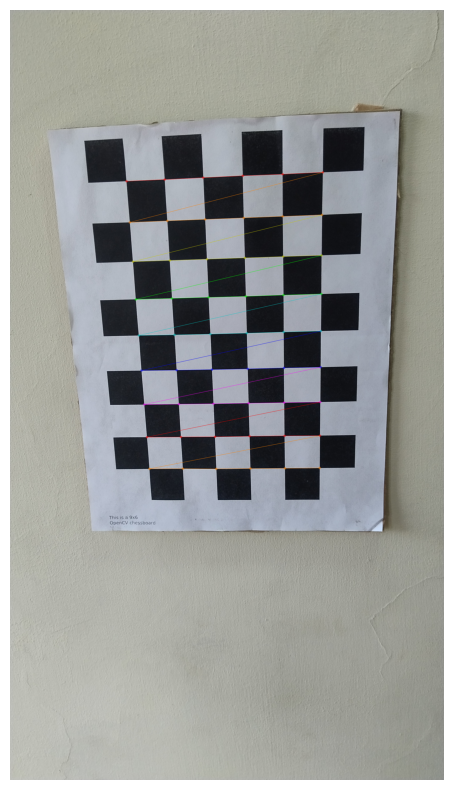

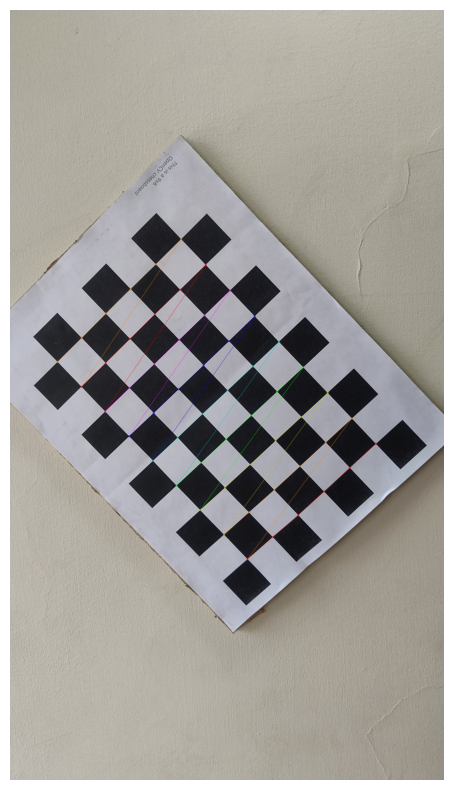

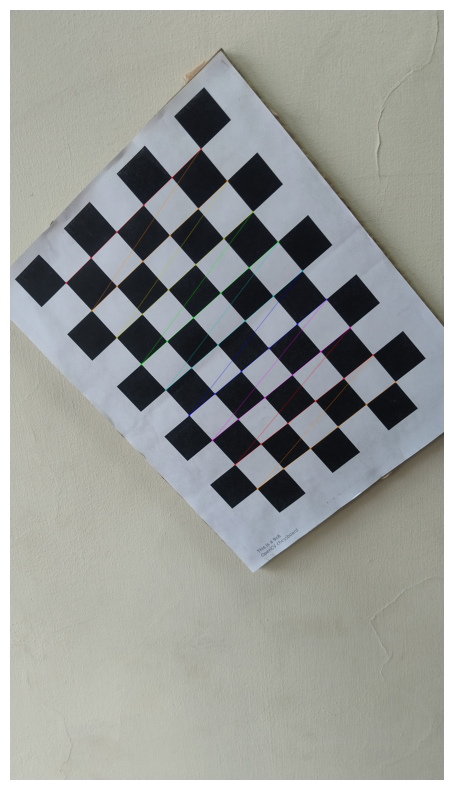

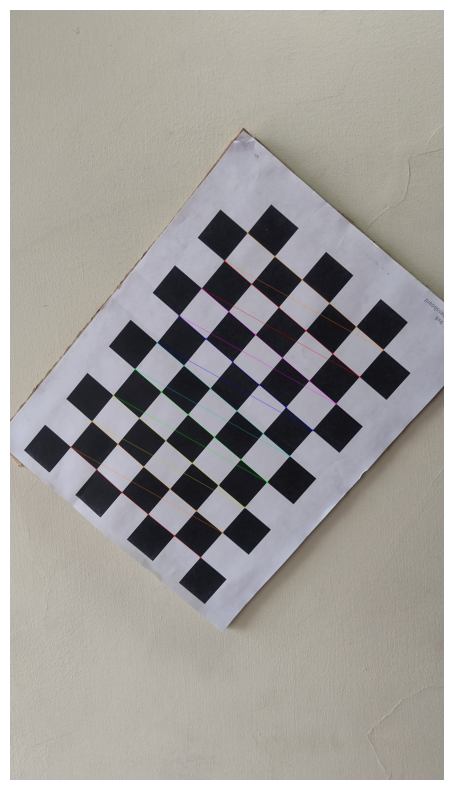

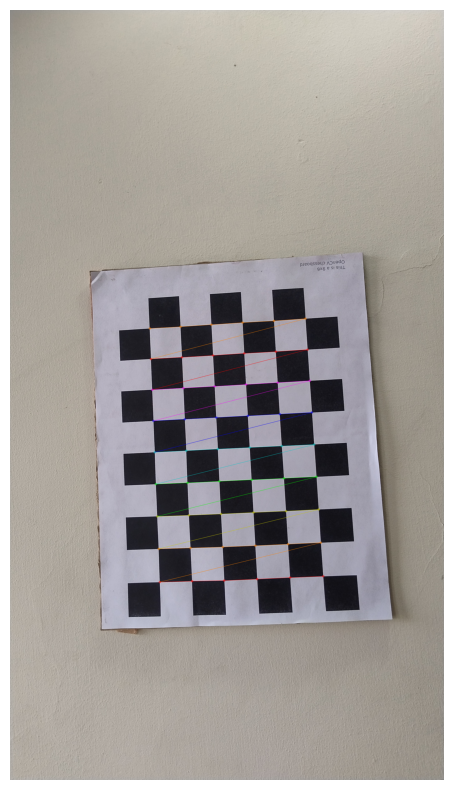

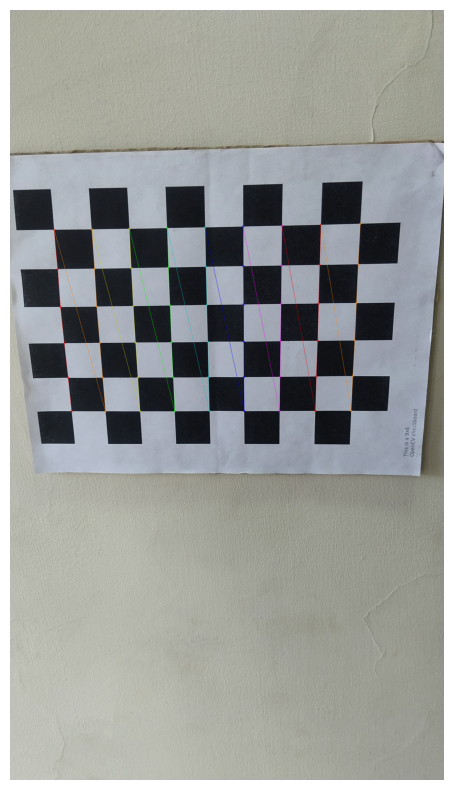

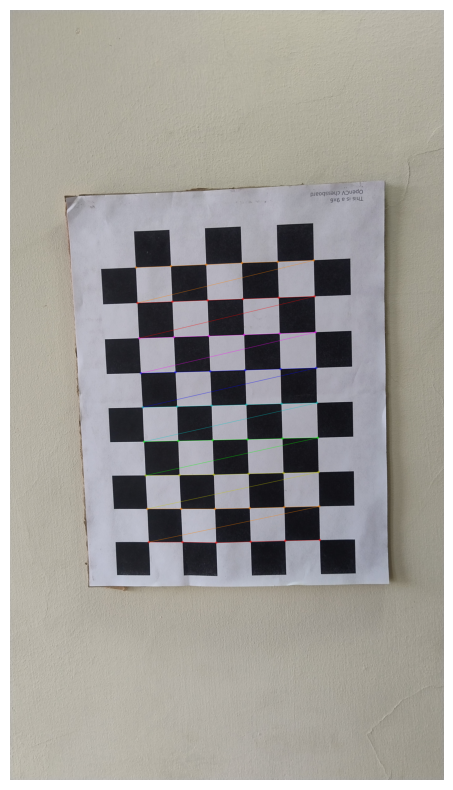

retval :  1.543660765306759
Camera matrix : 

[[2.84822217e+03 0.00000000e+00 1.15093618e+03]
 [0.00000000e+00 2.84938203e+03 2.03476537e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
dist : 

[[ 6.17606916e-02 -7.49744761e-01 -2.16294528e-03  1.48291909e-03
   2.47702567e+00]]
rvecs : 

(array([[ 0.10797935],
       [-0.01410327],
       [ 1.56356421]]), array([[0.01723841],
       [0.155607  ],
       [2.35560037]]), array([[-0.02994839],
       [ 0.13112903],
       [ 1.50535451]]), array([[-0.11277389],
       [-0.09695572],
       [-2.42854018]]), array([[ 0.27794618],
       [-0.01190704],
       [ 0.66898161]]), array([[ 0.27294525],
       [ 0.07236846],
       [-0.02627574]]), array([[ 0.09841261],
       [-0.05943393],
       [ 2.37932971]]), array([[ 0.23761961],
       [ 0.15483202],
       [-0.71395081]]), array([[-0.03061348],
       [ 0.10922867],
       [-2.43335934]]), array([[0.0856621 ],
       [0.16464303],
       [3.08135931]]), array([[ 0.17005181],
       

In [ ]:
# Defining the dimensions of checkerboard
CHECKERBOARD = (6,9)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Creating vector to store vectors of 3D points for each checkerboard image
objpoints = []
# Creating vector to store vectors of 2D points for each checkerboard image
imgpoints = []

# Defining the world coordinates for 3D points
objp = np.zeros((1, CHECKERBOARD[0]*CHECKERBOARD[1], 3), np.float32)
objp[0,:,:2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)
prev_img_shape = None

gray = None

# Ruta de las imágenes (ajusta si están en otra carpeta)
images = glob.glob('./Imágenes Calibración/*.jpg')

print(f"Imágenes encontradas: {len(images)}")
for i, f in enumerate(images):
    print(f"{i+1}. {f}")

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(
        gray, CHECKERBOARD,
        cv2.CALIB_CB_ADAPTIVE_THRESH +
        cv2.CALIB_CB_FAST_CHECK +
        cv2.CALIB_CB_NORMALIZE_IMAGE
    )

    if ret:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)
        img = cv2.drawChessboardCorners(img, CHECKERBOARD, corners2, ret)

    # --- Mostrar en notebook con matplotlib ---
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10,10))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

# --- Calibración ---
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
print("retval : ", ret)
print("Camera matrix : \n")
print(mtx)
print("dist : \n")
print(dist)
print("rvecs : \n")
print(rvecs)
print("tvecs : \n")
print(tvecs)


In [24]:
# --- CALCULO DEL ERROR RMS DE REPROYECCIÓN ---

mean_error = 0
total_points = 0

# Iterar sobre cada conjunto de puntos 3D (objpoints) e
# y sus correspondientes puntos 2D detectados (imgpoints)
for i in range(len(objpoints)):
    # 1. Reproyectar los puntos 3D al plano de la imagen (usando la calibración calculada)
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)

    # 2. Calcular la norma de la diferencia entre los puntos detectados (imgpoints)
    # y los puntos reproyectados (imgpoints2)
    # cv2.NORM_L2 calcula la distancia euclidiana (distancia en píxeles)
    error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2) / len(imgpoints2)

    # Acumular el error
    mean_error += error
    total_points += len(imgpoints2)

# 3. Calcular el promedio de los errores de todas las imágenes
final_rms_error = mean_error / len(objpoints)

print("\n--- Resultados de Precisión ---")
print(f"Error RMS de Reproyección (promedio por imagen): {final_rms_error} píxeles")
print(f"Error RMS (valor ret de calibrateCamera): {ret}")


--- Resultados de Precisión ---
Error RMS de Reproyección (promedio por imagen): 0.20846876134339556 píxeles
Error RMS (valor ret de calibrateCamera): 1.543660765306759
